# Stock Price Prediction

In this project, we'll predict stock prices using historical data.  To do that, we'll

* Download historical stock prices from Yahoo finance
* Explore the data
* Ensure that we're predicting future prices using historical prices
* Setup a backtesting engine
* Test a machine learnig model
* Add more indicators

At the end, we'll document some potential future directions we can do in.

## Downloading the data

First, we'll download the data from Yahoo Finance.  We'll save the data after we download it, so we don't have to re-download it every time (this could cause our IP to get blocked).

In [93]:
# Import finance API and get historical stock data

import yfinance as yf
import os
import json
import pandas as pd

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)

As we can see, we have one row of data for each day that Microsoft stock was traded.  This shows the following:

* Open - the price the stock opened at.
* High - the highest price during the day
* Low - the lowest price during the day
* Close - the closing price
* Volume - how many shares were traded

In [94]:
# Display microsoft stock price history so we can look at the structure of the data
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055898,0.064119,0.055898,0.061378,1031788800,0.0,0.0
1986-03-14,0.061378,0.064667,0.061378,0.063570,308160000,0.0,0.0
1986-03-17,0.063570,0.065215,0.063570,0.064667,133171200,0.0,0.0
1986-03-18,0.064667,0.065215,0.062474,0.063022,67766400,0.0,0.0
1986-03-19,0.063022,0.063570,0.061378,0.061926,47894400,0.0,0.0


Next, we'll plot the data so we can see how the stock price has changed over time.

<AxesSubplot:xlabel='Date'>

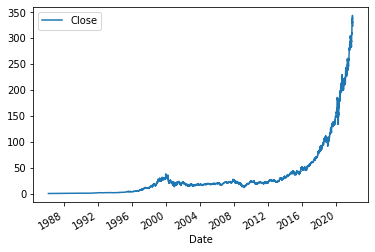

In [95]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

## Preparing the data

Now, let's prepare the data so we can make predictions.  We'll be predicting tomorrow's close price using data from today.

First, we'll identify a target that we're trying to predict.  That is each day's closing price.

Next, we'll shift the data from previous days "forward" one day, so we can use it to predict the target price.

Then, we'll combine both so we have our training data.

In [96]:
# Setup the target we're trying to predict
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Target'})

In [97]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)
msft_prev

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055898,0.064119,0.055898,0.061378,1.031789e+09,0.0,0.0
1986-03-17,0.061378,0.064667,0.061378,0.063570,3.081600e+08,0.0,0.0
1986-03-18,0.063570,0.065215,0.063570,0.064667,1.331712e+08,0.0,0.0
1986-03-19,0.064667,0.065215,0.062474,0.063022,6.776640e+07,0.0,0.0
...,...,...,...,...,...,...,...
2021-11-29,334.350006,337.929993,328.119995,329.679993,2.421720e+07,0.0,0.0
2021-11-30,334.940002,339.029999,334.739990,336.630005,2.856350e+07,0.0,0.0
2021-12-01,335.320007,337.779999,328.989990,330.589996,4.288560e+07,0.0,0.0


In [98]:
# Create our training data

predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]
data.head(5)

,Target,Close,Volume,Open,High,Low
Date,,,,,,
1986-03-14,0.063570,0.061378,1.031789e+09,0.055898,0.064119,0.055898
1986-03-17,0.064667,0.063570,3.081600e+08,0.061378,0.064667,0.061378
1986-03-18,0.063022,0.064667,1.331712e+08,0.063570,0.065215,0.063570
1986-03-19,0.061926,0.063022,6.776640e+07,0.064667,0.065215,0.062474
1986-03-20,0.060282,0.061926,4.789440e+07,0.063022,0.063570,0.061378


## Creating a machine learning model

Next, we'll create a machine learning model to see how accurately we can predict the stock price.

Because we're dealing with time series data, we can't just use cross-validation to create predictions for the whole dataset.  Instead, we have to use earlier data to predict later rows.

We'll start off by predicting just the last 100 rows.  We'll use a random forest model to generate our predictions.

In [99]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

np.random.seed(1) 

model = RandomForestRegressor(n_estimators=100)

train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestRegressor()

In [112]:
from sklearn.metrics import mean_absolute_error

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
mean_absolute_error(test["Target"], preds)

25.604716235351557

In [114]:
pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

,Target,Predictions
Date,,
2021-07-15,279.980774,278.958139
2021-07-16,279.701843,278.958139
2021-07-19,275.975830,279.226235
2021-07-20,278.277191,278.686149
2021-07-21,280.349396,277.864330
...,...,...
2021-11-29,336.630005,278.954154
2021-11-30,330.589996,279.226235
2021-12-01,330.079987,279.422497
